In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [586]:
appointment=pd.read_excel("D:\OneDrive\After Hours Assessment\Appointment Data.xlsx",dtype={'PROVIDER_ID': str,'PATIENT_ID': str})

In [261]:
appointment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125053 entries, 0 to 125052
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   FACILITY          125053 non-null  object        
 1   DEPARTMENT        125053 non-null  object        
 2   PROVIDER_ID       125053 non-null  object        
 3   APPOINTMENT_DATE  125053 non-null  datetime64[ns]
 4   APPOINTMENT_TIME  125053 non-null  object        
 5   PATIENT_ID        125053 non-null  object        
 6   APPOINTMENT_TYPE  125053 non-null  object        
 7   BOOKING_DATE      125053 non-null  datetime64[ns]
 8   BOOKING_TIME      125053 non-null  object        
 9   SHOW_CODE         125053 non-null  object        
 10  CHECKIN_DATE      111768 non-null  datetime64[ns]
 11  CHECKIN_TIME      111768 non-null  object        
dtypes: datetime64[ns](3), object(9)
memory usage: 11.4+ MB


In [262]:
appointment = appointment.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

,FACILITY,DEPARTMENT,PROVIDER_ID,APPOINTMENT_DATE,APPOINTMENT_TIME,PATIENT_ID,APPOINTMENT_TYPE,BOOKING_DATE,BOOKING_TIME,SHOW_CODE,CHECKIN_DATE,CHECKIN_TIME
0,SCH,MED,01571160,2010-03-31,11:35:00,00000126,In-Person Visit,2010-03-31,09:37:00,Y,2010-03-31,12:18:00
1,SCH,MED,01571160,2010-05-13,13:50:00,00000126,In-Person Visit,2010-05-10,11:00:00,Y,2010-05-13,13:31:00
2,SCH,MED,28685352,2010-03-29,10:30:00,00000126,In-Person Visit,2010-03-29,09:26:00,Y,2010-03-29,10:35:00
3,SCH,MED,39560883,2010-01-21,11:40:00,00000605,In-Person Visit,2010-01-15,13:31:00,Y,2010-01-21,11:46:00
4,SCH,MED,04621300,2010-02-02,13:30:00,00000687,Telephone Visit,2010-02-02,10:20:00,N,NaT,NaN


In [263]:
appointment['CHECKIN_TIME'] = pd.to_datetime(appointment['CHECKIN_TIME'], format='%H:%M:%S')
appointment['APPOINTMENT_TIME'] = pd.to_datetime(appointment['APPOINTMENT_TIME'], format='%H:%M:%S')
appointment['BOOKING_TIME'] = pd.to_datetime(appointment['BOOKING_TIME'], format='%H:%M:%S')
appointment['APPOINTMENT_HOUR']= appointment['APPOINTMENT_TIME'].dt.hour

In [264]:
after_hours_tel = appointment[(appointment['APPOINTMENT_TIME'] > pd.to_datetime('17:30:00', format='%H:%M:%S')) /
& (appointment['APPOINTMENT_TYPE'] == 'Telephone Visit')]
print(appointment.shape)
print(after_hours_tel.shape)

(125053, 13)
(4075, 13)


In [ ]:
count_by_hour=after_hours_tel.groupby(['APPOINTMENT_HOUR']).size().reset_index(name='count')

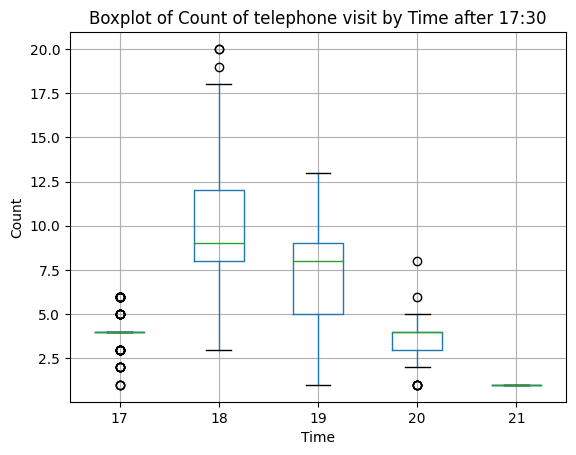

In [377]:
count_by_date_hour = after_hours_tel.groupby(['APPOINTMENT_DATE','APPOINTMENT_HOUR']).size().reset_index(name='count')
pivot=count_by_date_hour.pivot(columns='APPOINTMENT_HOUR',values='count')
pivot.boxplot()
plt.title('Boxplot of Count of telephone visit by Time after 17:30')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()

In [394]:
percentile = pd.DataFrame(columns=['APPOINTMENT_HOUR', '95th_percentile'])
n = 0
for i in set(count_by_date_hour['APPOINTMENT_HOUR']):
    pt = count_by_date_hour[count_by_date_hour['APPOINTMENT_HOUR'] == i]['count'].quantile(0.95)
    percentile.loc[n, 'APPOINTMENT_HOUR'] = i
    percentile.loc[n, '95th_percentile'] = pt
    n = n + 1
percentile

,APPOINTMENT_HOUR,95th_percentile
0,17,6.0
1,18,16.0
2,19,13.0
3,20,4.05
4,21,1.0


In [387]:
import scipy.stats
data_hour_18 = count_by_date_hour[count_by_date_hour['APPOINTMENT_HOUR'] == 18]['count']
print(scipy.stats.percentileofscore(data_hour_18, 12))
print(pivot.describe().round(3))

78.23834196891191
APPOINTMENT_HOUR       17       18       19      20   21
count             135.000  193.000  191.000  60.000  1.0
mean                4.133    9.627    7.581   3.500  1.0
std                 1.098    3.257    2.831   1.214  NaN
min                 1.000    3.000    1.000   1.000  1.0
25%                 4.000    8.000    5.000   3.000  1.0
50%                 4.000    9.000    8.000   4.000  1.0
75%                 4.000   12.000    9.000   4.000  1.0
max                 6.000   20.000   13.000   8.000  1.0


In [372]:
pd.DataFrame(count_by_date_hour.loc[:,'count'].describe())

,count
count,580.000000
mean,7.025862
std,3.497992
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,20.000000


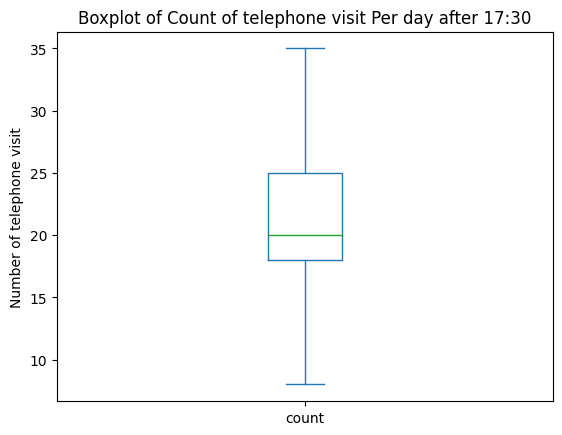

95th quantile is  29.0


,count
count,193.000
mean,21.114
std,5.358
min,8.000
25%,18.000
50%,20.000
75%,25.000
max,35.000


In [562]:
count_by_date = after_hours_tel.groupby(['APPOINTMENT_DATE']).size().reset_index(name='count')
count_by_date['count'].plot.box()
plt.title('Boxplot of Count of telephone visit Per day after 17:30')
plt.xlabel('')
plt.ylabel('Number of telephone visit')
plt.show()
print('95th quantile is ',count_by_date['count'].quantile(0.95))
count_by_date.set_index(['APPOINTMENT_DATE']).describe().round(3)

In [438]:
df=appointment.copy() #If need BOOKING_DATE - APPOINTMENT_DATE in differnt row, can use shift(-1)
df['EFFECTIVE']='effective'
df=df.sort_values(by='APPOINTMENT_DATE',ascending=False)
df['DAYS_TO_NEXT_APPT'] = -df.groupby('PATIENT_ID')['APPOINTMENT_DATE'].diff().dt.days
df.loc[df['DAYS_TO_NEXT_APPT'] <= 7, 'EFFECTIVE'] = 'not effective'
df.sort_values(['PATIENT_ID','APPOINTMENT_DATE']).iloc[:6,[3,5,13,14]]

,APPOINTMENT_DATE,PATIENT_ID,EFFECTIVE,DAYS_TO_NEXT_APPT
2,2010-03-29,00000126,not effective,2.0
0,2010-03-31,00000126,effective,43.0
1,2010-05-13,00000126,effective,NaN
3,2010-01-21,00000605,effective,NaN
5,2010-02-02,00000687,effective,NaN
4,2010-02-02,00000687,not effective,-0.0


In [439]:
df['CHECKIN_TIME'] = pd.to_datetime(df['CHECKIN_TIME'], format='%H:%M:%S')
df['APPOINTMENT_TIME'] = pd.to_datetime(df['APPOINTMENT_TIME'], format='%H:%M:%S')
df['BOOKING_TIME'] = pd.to_datetime(df['BOOKING_TIME'], format='%H:%M:%S')
df['BOOKING_HOUR']=df['BOOKING_TIME'].dt.hour
df['APPOINTMENT_HOUR']=df['APPOINTMENT_TIME'].dt.hour

In [497]:
df_aft_tel_ef = df[(df['APPOINTMENT_TIME'] > pd.to_datetime('17:30:00', format='%H:%M:%S')) \
& (df['APPOINTMENT_TYPE'] == 'Telephone Visit')]
pd.DataFrame(df_aft_tel_ef.value_counts('EFFECTIVE'))

,count
EFFECTIVE,
effective,2760
not effective,1315


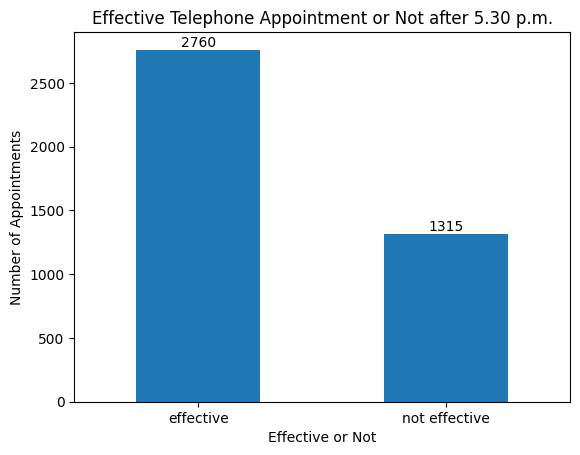

In [498]:
category_counts = df_aft_tel_ef['EFFECTIVE'].value_counts()
category_counts.plot(kind='bar', rot=0)  # rot=0用于控制 x 轴标签的旋转

# 显示柱状图上的值
for i, count in enumerate(category_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# 添加图标题和标签
plt.title('Effective Telephone Appointment or Not after 5.30 p.m.')
plt.xlabel('Effective or Not')
plt.ylabel('Number of Appointments')

# 显示图形
plt.show()

In [575]:
df['EFFECTIVE'].value_counts()

EFFECTIVE
effective        111516
not effective     13537
Name: count, dtype: int64

P-value for Levene's test: 0.8839255742811336
P-value for Shapiro-Wilk test for group 1: 0.1442764550447464


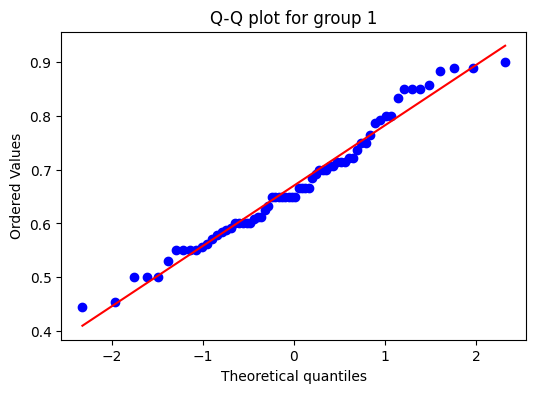

P-value for Shapiro-Wilk test for group 2: 0.5106460452079773


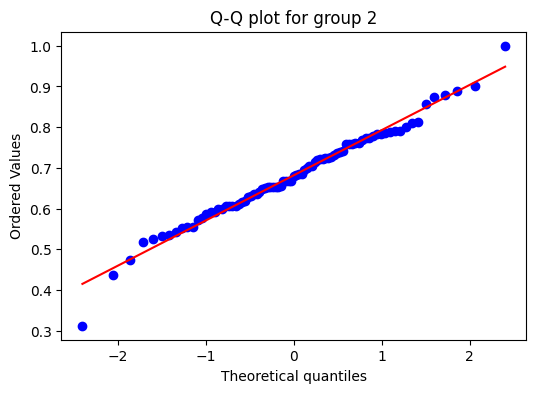

P-value for Shapiro-Wilk test for group 3: 0.7603441476821899


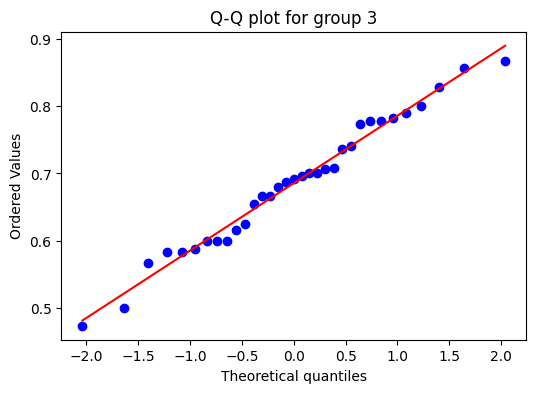

P-value for Shapiro-Wilk test for group 4: 0.2391485571861267


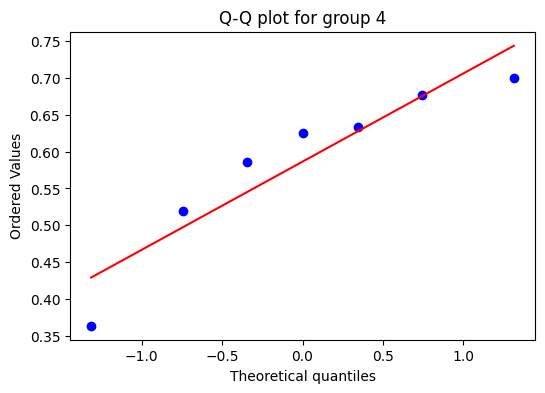

In [565]:
df_aft_tel_ef.loc[:,'EFFECTIVE_BINARY'] = df_aft_tel_ef['EFFECTIVE'].apply(lambda x: 1 if x == 'effective' else 0)
daily_analysis = df_aft_tel_ef.groupby('APPOINTMENT_DATE').agg({
    'PROVIDER_ID': pd.Series.nunique,  # Count of unique PROVIDER_ID
    'EFFECTIVE_BINARY': 'mean'  # Mean of EFFECTIVE_BINARY
}).reset_index()
daily_analysis.columns = ['APPOINTMENT_DATE', 'UNIQUE_PROVIDER_COUNT', 'EFFECTIVE_RATIO']
# Grouping of data for each group
groups = [group["EFFECTIVE_RATIO"].values for name, group in daily_analysis.groupby("UNIQUE_PROVIDER_COUNT")]

# Checking for chi-square (Levene's test)
_, p_value_levene = stats.levene(*groups)
print(f"P-value for Levene's test: {p_value_levene}")

# Check Normal Distribution（Shapiro-Wilk test, QQ plot）
for i, group in enumerate(groups):
    _, p_value_shapiro = stats.shapiro(group)
    print(f"P-value for Shapiro-Wilk test for group {i+1}: {p_value_shapiro}")
    
    # 绘制 Q-Q plot
    plt.figure(figsize=(6, 4))
    stats.probplot(group, plot=sns.mpl.pyplot)
    plt.title(f"Q-Q plot for group {i+1}")
    plt.show()

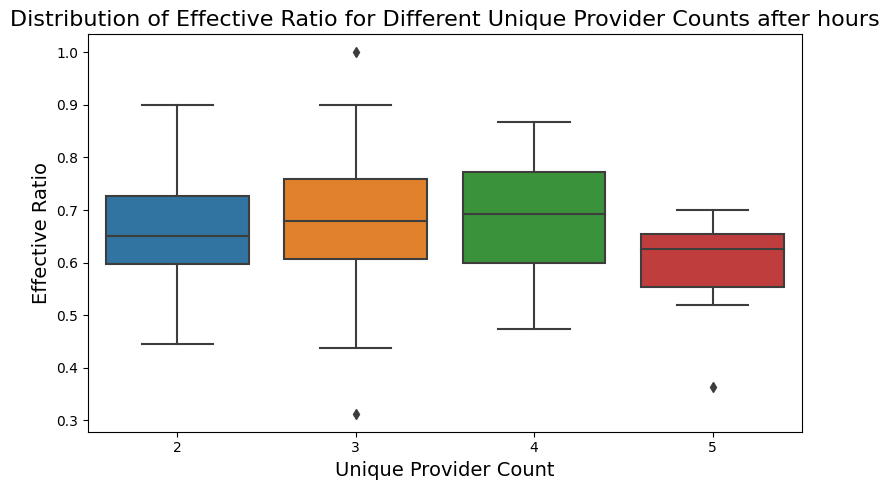

UNIQUE_PROVIDER_COUNT       2       3       4      5
count                  68.000  85.000  33.000  7.000
mean                    0.670   0.682   0.686  0.586
std                     0.111   0.110   0.097  0.115
min                     0.444   0.312   0.474  0.364
25%                     0.598   0.607   0.600  0.553
50%                     0.650   0.680   0.692  0.625
75%                     0.726   0.759   0.773  0.655
max                     0.900   1.000   0.867  0.700


,F-statistic,P-value
0,1.818807,0.145161


In [566]:
# Rename the columns for clarity
plt.figure(figsize=(8, 5))
sns.boxplot(x='UNIQUE_PROVIDER_COUNT', y='EFFECTIVE_RATIO', data=daily_analysis)

# Adding title and labels
plt.title('Distribution of Effective Ratio for Different Unique Provider Counts after hours', fontsize=16)
plt.xlabel('Unique Provider Count', fontsize=14)
plt.ylabel('Effective Ratio', fontsize=14)

# Displaying the plot
plt.tight_layout()
plt.show()
print(daily_analysis.pivot(columns='UNIQUE_PROVIDER_COUNT',values='EFFECTIVE_RATIO').describe().round(3))
import scipy.stats as stats
groups = [group["EFFECTIVE_RATIO"].values for name, group in daily_analysis.groupby("UNIQUE_PROVIDER_COUNT")]
f_stat, p_value = stats.f_oneway(*groups)
pd.DataFrame({'F-statistic': [f_stat],'P-value': [p_value]})

In [573]:
daily_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   APPOINTMENT_DATE       193 non-null    datetime64[ns]
 1   UNIQUE_PROVIDER_COUNT  193 non-null    int64         
 2   EFFECTIVE_RATIO        193 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.7 KB


In [574]:
import statsmodels.api as sm

# Process data
X = daily_analysis['UNIQUE_PROVIDER_COUNT']  # Independent factors
y = daily_analysis['EFFECTIVE_RATIO']  # Dependent factors

X = sm.add_constant(X)

# Creating multiple linear regression models
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        EFFECTIVE_RATIO   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2080
Date:                Wed, 04 Oct 2023   Prob (F-statistic):              0.649
Time:                        17:44:33   Log-Likelihood:                 154.06
No. Observations:                 193   AIC:                            -304.1
Df Residuals:                     191   BIC:                            -297.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.68

In [576]:
show_analysis = df_aft_tel_ef.groupby('SHOW_CODE').agg({
    'EFFECTIVE_BINARY': 'mean'  # Mean of EFFECTIVE_BINARY
}).reset_index()
show_analysis.head()

,SHOW_CODE,EFFECTIVE_BINARY
0,N,0.683521
1,P,0.665480
2,Y,0.677301


In [502]:
# Group by 'PROVIDER_ID' and calculate the 'EFFECTIVE_RATIO' per provider
provider_analysis = df_aft_tel_ef.groupby('PROVIDER_ID').agg({
    'EFFECTIVE_BINARY': 'mean'  # Mean of EFFECTIVE_BINARY
}).reset_index()
# Rename the column for clarity
provider_analysis.columns = ['PROVIDER_ID', 'EFFECTIVE_RATIO']
# Display basic statistics and first few rows of provider_analysis
pd.DataFrame(provider_analysis['EFFECTIVE_RATIO'].describe())
pd.DataFrame(provider_analysis.sort_values(by='EFFECTIVE_RATIO',ascending=False).head(10)).round(2)

,PROVIDER_ID,EFFECTIVE_RATIO
19,22292052,1.00
2,01571160,1.00
65,59874975,1.00
11,12801161,0.92
10,11574621,0.92
52,46301464,0.90
3,04149630,0.89
104,91668939,0.87
63,57025795,0.87
94,80252478,0.86


In [582]:
# Extract day of week from 'APPOINTMENT_DATE'
df_aft_tel_ef['DAY_OF_WEEK'] = df_aft_tel_ef['APPOINTMENT_DATE'].dt.day_name()

# Group by 'APPOINTMENT_HOUR' and calculate the 'EFFECTIVE_RATIO' per hour
hourly_analysis = df_aft_tel_ef.groupby('APPOINTMENT_HOUR').agg({
    'EFFECTIVE_BINARY': 'mean'  # Mean of EFFECTIVE_BINARY
}).reset_index()

# Rename the column for clarity
hourly_analysis.columns = ['APPOINTMENT_HOUR', 'EFFECTIVE_RATIO']

# Group by 'DAY_OF_WEEK' and calculate the 'EFFECTIVE_RATIO' per day of week
daily_analysis = df_aft_tel_ef.groupby('DAY_OF_WEEK').agg({
    'EFFECTIVE_BINARY': 'mean'  # Mean of EFFECTIVE_BINARY
}).reset_index()

# Rename the column for clarity
daily_analysis.columns = ['DAY_OF_WEEK', 'EFFECTIVE_RATIO']

# Order the days of the week
ordered_days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_analysis['DAY_OF_WEEK'] = pd.Categorical(daily_analysis['DAY_OF_WEEK'], categories=ordered_days_of_week, ordered=True)
daily_analysis = daily_analysis.sort_values('DAY_OF_WEEK')

# Display first few rows of hourly_analysis and daily_analysis
(hourly_analysis.head(), daily_analysis.head(7))


(   APPOINTMENT_HOUR  EFFECTIVE_RATIO
 0                17         0.659498
 1                18         0.686222
 2                19         0.679558
 3                20         0.628571
 4                21         1.000000,
   DAY_OF_WEEK  EFFECTIVE_RATIO
 1      Monday         0.698908
 5     Tuesday         0.659696
 6   Wednesday         0.681973
 4    Thursday         0.673633
 0      Friday         0.672753
 2    Saturday         0.678505
 3      Sunday         0.671840)

In [583]:
set(df_aft_tel_ef['DAY_OF_WEEK'])

{'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'}

In [584]:
time_analysis=df_aft_tel_ef.groupby(['APPOINTMENT_DATE','APPOINTMENT_HOUR']).agg({
    'EFFECTIVE_BINARY': 'mean' , 'DAY_OF_WEEK': 'first' # Mean of EFFECTIVE_BINARY
}).reset_index()

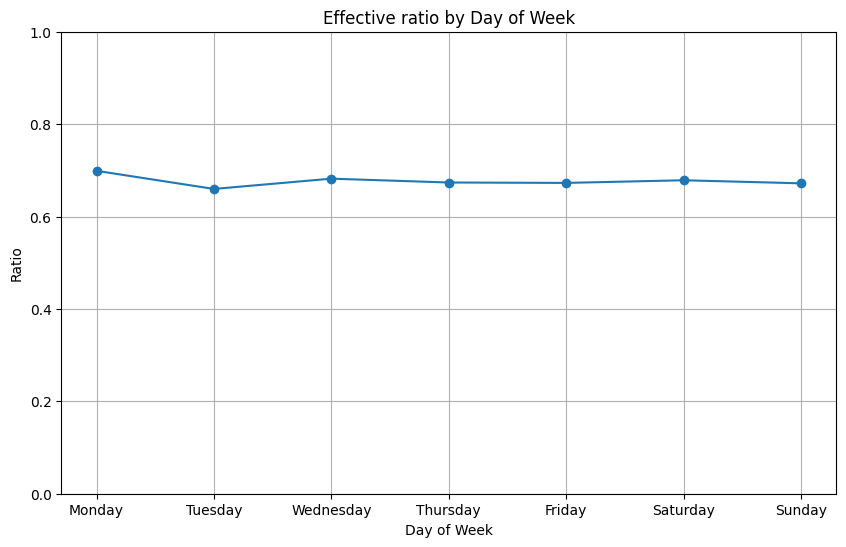

In [585]:
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.plot(daily_analysis.DAY_OF_WEEK, daily_analysis['EFFECTIVE_RATIO'], marker='o', linestyle='-')
plt.yticks(np.arange(0, 1.2, step=0.2))
plt.xlabel('Day of Week')
plt.ylabel('Ratio')
plt.title('Effective ratio by Day of Week')
plt.grid(True)
plt.show()

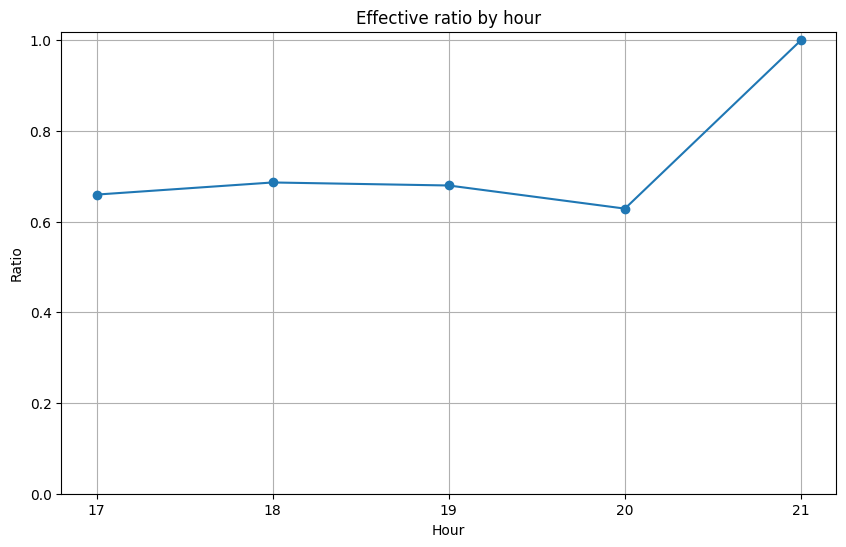

In [578]:
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.plot(hourly_analysis.APPOINTMENT_HOUR, hourly_analysis['EFFECTIVE_RATIO'], marker='o', linestyle='-')
plt.xticks(range(min(hourly_analysis.APPOINTMENT_HOUR), max(hourly_analysis.APPOINTMENT_HOUR)+1, 1))
plt.yticks(np.arange(0, 1.2, step=0.2))
plt.xlabel('Hour')
plt.ylabel('Ratio')
plt.title('Effective ratio by hour')
plt.grid(True)
plt.show()

In [557]:
from scipy.stats import levene
# Checking for variance alignment using Levene's test

grouped_data = [group["EFFECTIVE_BINARY"] for name, group in time_analysis.groupby(['APPOINTMENT_HOUR', 'DAY_OF_WEEK'])]
result = levene(*grouped_data)

print("Levene's:", result.statistic)
print("p-value:", result.pvalue)

alpha = 0.05  # significant level
if result.pvalue < alpha:
    print("Reject hypothesis")
else:
    print("Accept hypothesis")
from scipy.stats import shapiro

# Test if normal distribution
statistic, p_value = shapiro(time_analysis["EFFECTIVE_BINARY"])

print("Shapiro-Wilk:", statistic)
print("p-value:", p_value)

alpha = 0.05  
if p_value < alpha:
    print("Not normal distribution")
else:
    print("Normal Distribution")

Levene's统计量: 1.7785473371794522
p-value: 0.014556624657041746
拒绝原假设：方差不齐性
Shapiro-Wilk统计量: 0.9573944211006165
p-value: 6.58131925693195e-12
拒绝原假设：数据不符合正态分布


In [558]:
# Test if change of appointment_hour and day_of_week cause different of effective
from scipy.stats import kruskal
result = kruskal(*[group["EFFECTIVE_BINARY"] for name, group in time_analysis.groupby(['APPOINTMENT_HOUR', 'DAY_OF_WEEK'])])

print("Kruskal-Wallis:", result.statistic)
print("p-value:", result.pvalue)

alpha = 0.05  
if result.pvalue < alpha:
    print("There is significant difference during groups")
else:
    print("There is not significant difference during groups")

Kruskal-Wallis统计量: 16.110199402645687
p-value: 0.8505107639755887
接受原假设：组之间没有显著差异


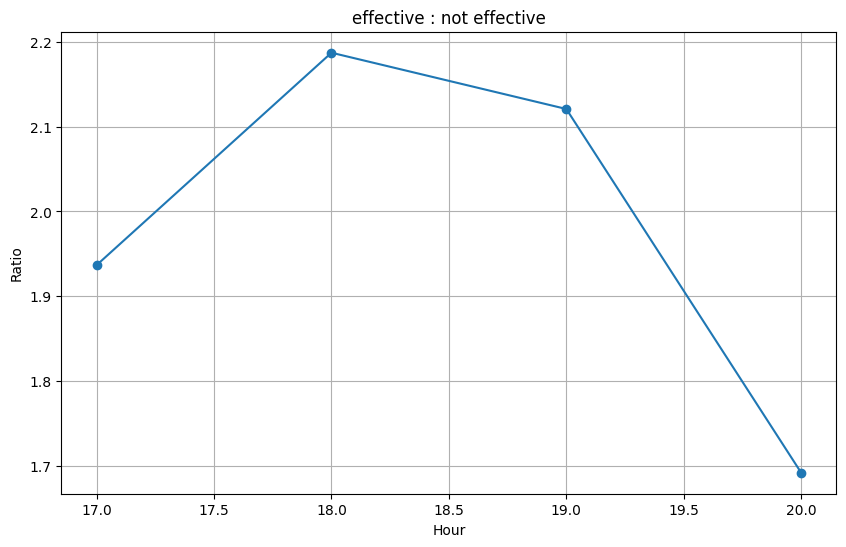

In [355]:
ef_n_hour=df_aft_tel_ef.groupby(['APPOINTMENT_HOUR','EFFECTIVE']).size().reset_index().pivot(index='APPOINTMENT_HOUR',columns='EFFECTIVE',values=0)
plt.figure(figsize=(10, 6))  
plt.plot(ef_n_hour.index, ef_n_hour['effective']/ef_n_hour['not effective'], marker='o', linestyle='-')
plt.xlabel('Hour')
plt.ylabel('Ratio')
plt.title('effective : not effective')
plt.grid(True)
plt.show()

In [354]:
ef_n_hour

EFFECTIVE,effective,not effective
APPOINTMENT_HOUR,,
17,368.0,190.0
18,1275.0,583.0
19,984.0,464.0
20,132.0,78.0
21,1.0,NaN


D:\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


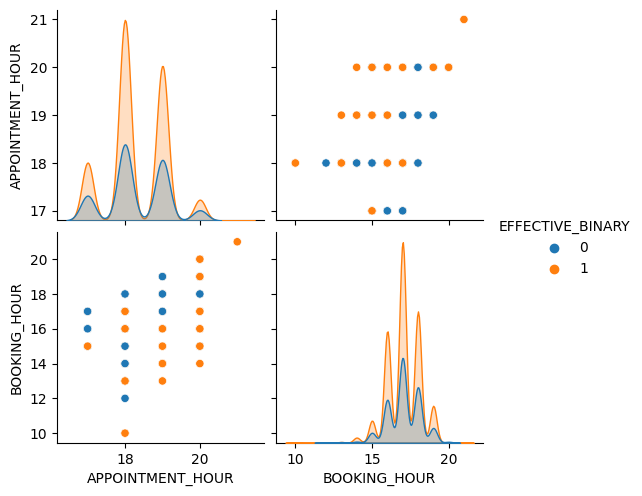

In [364]:
variables_to_plot=['APPOINTMENT_HOUR','BOOKING_HOUR','DAY_OF_WEEK','PROVIDER_ID','EFFECTIVE_BINARY']
sns.pairplot(df_aft_tel_ef[variables_to_plot], hue='EFFECTIVE_BINARY')